# BDB VI Project

## Imports

In [281]:
import pandas
import numpy
import scipy
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from python_tsp.distances import euclidean_distance_matrix
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.exact import solve_tsp_brute_force
from python_tsp.exact.branch_and_bound import solve_tsp_branch_and_bound


import os
os.chdir(r'G:/My Drive/Colab Notebooks/CFL Analytics Project/')
import PIL
from math_functions import *
import axes_functions

from axes_functions import WatermarkFigure
from axes_functions import Concordia_figure
matplotlib.axes.Axes.plot_svg = axes_functions.plot_svg
matplotlib.axes.Axes.plot_png = axes_functions.plot_png
matplotlib.axes.Axes.plot_image = axes_functions.plot_image
matplotlib.axes.Axes.image_scatter = axes_functions.image_scatter
matplotlib.axes.Axes.trend_line = axes_functions.trend_line
matplotlib.axes.Axes.ROC_graph = axes_functions.ROC_graph
matplotlib.axes.Axes.precision_recall_graph = axes_functions.precision_recall_graph
matplotlib.axes.Axes.detection_error_graph = axes_functions.detection_error_graph
matplotlib.axes.Axes.continuous_errorbar = axes_functions.continuous_errorbar
matplotlib.axes.Axes.binomial_errorbar = axes_functions.binomial_errorbar

## Get Data

In [282]:
'''
Import the data
do the cleanup'''

def get_data():
    path = "C:\\Users\\clementchristopher\\Downloads\\nfl-big-data-bowl-2024\\"    
    games = pandas.read_csv(path+"games.csv", header=0,
                            dtype={'gameId': numpy.float64,
                                    'season': numpy.float64,
                                    'week': numpy.float64,
                                    # 'gameDate': pandas.datetime,
                                    # 'gameTimeEastern': pandas.timedelta,
                                    'homeFinalScore': numpy.float64,
                                    'visitorFinalScore': numpy.float64},
                            parse_dates=['gameDate'])

    players = pandas.read_csv(path+"players.csv", header=0,
                              dtype={'nflId': numpy.float64,
                                     #'height': numpy.float64,  # Need to convert this to a useful measure if I want to use it. Format is 5-8, 5-10, 6-1
                                     'weight': numpy.float64},
                                      parse_dates=['birthDate'])
    
    plays = pandas.read_csv(path+"plays.csv", header=0,
                            dtype={'gameId': numpy.float64,
                                   'playId': numpy.float64,
                                   'ballCarrierId': numpy.float64,
                                   'quarter': numpy.float64,
                                   'down': numpy.float64,
                                   'yardsToGo': numpy.float64,
                                   'yardlineNumber': numpy.float64,
                                   # 'gameClock': ,
                                   'preSnapHomeScore': numpy.float64,
                                   'preSnapVisitorScore': numpy.float64,
                                   'passLength': numpy.float64,
                                   'penaltyYards': numpy.float64,
                                   'absoluteYardlineNumber': numpy.float64,
                                   'defendersInTheBox': numpy.float64,
                                   'passProbability': numpy.float64,
                                   'preSnapHomeTeamWinProbability': numpy.float64,
                                   'preSnapVisitorTeamWinProbability': numpy.float64,
                                   'homeTeamWinProbabilityAdded': numpy.float64,
                                   'visitorTeamWinProbilityAdded': numpy.float64,
                                   'expectedPoints': numpy.float64,
                                   'expectedPointsAdded': numpy.float64,
                                   'foulNFLId1': numpy.float64,
                                   'foulNFLId2': numpy.float64,})
    tackles = pandas.read_csv(path+"tackles.csv", header=0,
                              dtype={'gameId': numpy.float64,
                                     'playId': numpy.float64,
                                     'nflId': numpy.float64,
                                     'tackle': numpy.float64,
                                     'assist': numpy.float64,
                                     'forcedFumble': numpy.float64,
                                     'pff_missedTackle': numpy.float64})

    tracking_sheets = []
    for week in range(1, 10):
        tracking_sheets.append(pandas.read_csv(path+"tracking_week_"+week.__str__()+".csv", header=0))
    tracking = pandas.concat(tracking_sheets)
    tracking = tracking.astype({'gameId': numpy.float64,
                                'playId': numpy.float64,
                                'nflId': numpy.float64,
                                'frameId': numpy.float64,
                                'jerseyNumber': numpy.float64,
                                'x': numpy.float64,
                                'y': numpy.float64,
                                's': numpy.float64,
                                'a': numpy.float64,
                                'dis': numpy.float64,
                                'o': numpy.float64,
                                'dir': numpy.float64})

    advantage = pandas.read_csv("G:\\My Drive\\Colab Notebooks\\CFL Analytics Project\\NFL BDB VI Advantage Data.csv", header=0,
                                     dtype={"gameId": numpy.float64,
                                            "playId": numpy.float64,})
    advantage = advantage.dropna()

    plays = plays.merge(advantage, how='outer', on=['gameId', 'playId'])
    plays["Advantage"] = plays["Advantage"].replace({"False": False, "True": True, "Nan": numpy.nan})

    missed_tackles = tackles[tackles["pff_missedTackle"] == 1]
    plays = plays.merge(missed_tackles[["gameId", "playId"]], how='outer', on=['gameId', 'playId'], indicator="missed_tackle")
    plays["missed_tackle"] = plays["missed_tackle"].replace({"both": True, "left_only": False, "right_only": numpy.nan})
    plays["missed_tackle"].replace({False: 0, True: 1}, inplace=True)

    return games, players, plays, tackles, tracking, advantage


def select_handoff_data(df, players):
    
    # Drop NA, there's a bunch of rows of na crap
    df = df[~df['x'].isna()]

    # Select only the plays with handoff data

    # Remove plays with no QB
    temp = df.merge(players[['nflId', 'position']], how='outer', on='nflId')
    temp = temp[temp['position'] == "QB"]
    # We need to match on game, play, and frame because these doofuses don't actually use *unique* IDs
    handoff_tracking = df.merge(temp[['gameId', 'playId', 'frameId']], how='inner', on=['gameId', 'playId', 'frameId'])
    
    
    temp = handoff_tracking[handoff_tracking['event'] == 'handoff'].groupby(['gameId', 'playId', 'frameId'], as_index=False)["x"].count()
    # Some of the plays don't have  lines, drop them
    temp = temp[temp['x'] == 23]
    handoff_tracking = handoff_tracking.merge(temp[['gameId', 'playId', 'frameId']], how='inner', on=['gameId', 'playId', 'frameId'])
    
    return handoff_tracking


def tracking_cleanup(df, plays):
    df = df.merge(plays[['gameId', 'playId', 'absoluteYardlineNumber', 'possessionTeam']], how='inner', on=['gameId', 'playId'])
    df['AdjustedX'] = df['x'] - df['absoluteYardlineNumber']
    df['OD'] = df['club'] == df['possessionTeam']

    df['AdjustedX'] = df['AdjustedX'].where(df['playDirection'] == 'right', df['AdjustedX'] * (-1)).round(3)
    df["AdjustedO"] = numpy.deg2rad(df["o"]).where(df["playDirection"] == "right", numpy.deg2rad(df["o"] * -1) + 2 * numpy.pi)
    df["AdjustedDir"] = numpy.deg2rad(df["dir"]).where(df["playDirection"] == "right", numpy.deg2rad(df["dir"] * -1) + 2 * numpy.pi)

    df = df.drop(['absoluteYardlineNumber', 'possessionTeam'], axis=1)
    return df


def advantage_data_to_csv():
    # Copy the data from the excel we're working in to a cleaner
    advantage_source = pandas.read_excel("G:\\My Drive\\Colab Notebooks\\CFL Analytics Project\\NFL BDB VI Advantage Tracking.xlsx", sheet_name="Advantage Data",
                                         usecols=["gameId", "playId", "Advantage"], header=0, dtype={"gameId": numpy.float64, 'playId': numpy.float64})
    advantage_source = advantage_source.dropna()
    advantage_source.to_csv("G:\\My Drive\\Colab Notebooks\\CFL Analytics Project\\NFL BDB VI Advantage Data.csv", index=False)
    return None

# Move the advantage tracking from excel to a separate csv
advantage_data_to_csv()

# initially pull in all the data
(games, players, plays, tackles, tracking, advantage) = get_data()

# Get the tracking data for the plays we care about
handoff_tracking = select_handoff_data(tracking, players)

# Clean up everything to be normalized around the 0 yardline
handoff_tracking = tracking_cleanup(handoff_tracking, plays)
print(handoff_plays[~handoff_plays["Advantage"].isna()].groupby("possessionTeam", as_index=False).size())

   possessionTeam  size
0             ARI    68
1             ATL   101
2             BAL    94
3             BUF    58
4             CAR    55
5             CHI    75
6             CIN    92
7             CLE   139
8             DAL    90
9             DEN    88
10            DET   100
11             GB    80
12            HOU    75
13            IND    86
14            JAX    75
15             KC    55
16             LA    56
17            LAC    71
18             LV    50
19            MIA    72
20            MIN    70
21             NE    64
22             NO    82
23            NYG    75
24            NYJ    52
25            PHI    62
26            PIT    51
27            SEA    55
28             SF    80
29             TB    69
30            TEN    65
31            WAS    78


## Data Prep

In [283]:

def prep_BDB_columns(df, plays, players):

    # Create a single column with everyone's coordinates in a single array
    df["XY"] = list(numpy.stack([df['AdjustedX'] + numpy.sin(df['AdjustedDir']) * df['s'], df['y'] + numpy.cos(df['AdjustedDir']) * df['s']], axis=-1))  # Plus one second on their current vector
    # df["XY"] = list(numpy.stack([df['AdjustedX'], df['y']], axis=-1))  # Simple position

    blockers = df[df['OD'] == True]
    blockers = blockers.merge(players[players['position'] != "QB"]['nflId'], how='inner', on='nflId')

    blockers = blockers.merge(plays[['gameId', 'playId', 'ballCarrierId']], how='inner', on=['gameId', 'playId'])  # Add the ballcarrierID column to blockers
    blockers = blockers[blockers['nflId'] != blockers['ballCarrierId']]
    blockers = blockers.drop(['ballCarrierId'], axis=1)

    # Get rid of plays that don't have exactly 9 blockers
    temp = blockers.groupby(['gameId', 'playId'], as_index=False).size()
    temp = temp[temp['size'] == 9]

    blockers = blockers.merge(temp[['gameId', 'playId']], how='inner', on=['gameId', 'playId'])

    temp = blockers.groupby(['gameId', 'playId'], as_index=False)['XY'].apply(numpy.array)
    temp = temp.rename(columns={'XY': "Blockers"})
    handoff_plays = plays.merge(temp, how='inner', on=['gameId', 'playId'])
    
    # Get array of defenders
    defenders = df[(df['OD'] == False) & (df['displayName'] != 'football')].groupby(['gameId', 'playId'], as_index=False)['XY'].apply(numpy.array)
    defenders = defenders.rename(columns={"XY": "Defenders"})
    handoff_plays = handoff_plays.merge(defenders, how='inner', on=['gameId', 'playId'])
    
    # Add ballCarrierXY to plays
    temp = df.merge(plays[['gameId', 'playId', 'ballCarrierId']], how='inner', left_on=['gameId', 'playId', 'nflId'], right_on=['gameId', 'playId', 'ballCarrierId'])
    temp = temp.rename(columns={'XY': 'ballCarrierXY'})
    handoff_plays = handoff_plays.merge(temp[['gameId', 'playId', 'ballCarrierXY']], how='inner', on=['gameId', 'playId'])

    return handoff_plays


def sort_gaps(plays):
    gaps_data = []
    for r, row in tqdm(plays.iterrows(), total=plays.__len__(), desc="Identifying gaps"):
        
        gaps = numpy.stack([[row['ballCarrierXY'][0], 0], *row['Blockers'], [row['ballCarrierXY'][0], 53.333]], axis=0)
        distance_matrix = euclidean_distance_matrix(gaps)  # Converts xy points into distances to do the traveling salesman problem
        distance_matrix[-1, 0] = 0  # I don't think we want this set to zero or it might go fully across the field first

        # Determine the most efficient routing. Returns a tuple of length 2, the first is a list of the order of the elements of tempxy, the second is the total length
        # order = solve_tsp_dynamic_programming(distance_matrix)
        # order = solve_tsp_brute_force(distance_matrix)
        order = solve_tsp_branch_and_bound(distance_matrix)
        segments = gaps[order[0]]  # Reorder the xy points of the players
        gaps_data.append(segments)
    
    plays['Gaps'] = gaps_data
    return plays


def lineseg_dists(p, a, b):

    # Handle case where p is a single point, i.e. 1d array.
    p = numpy.atleast_2d(p)

    if numpy.all(a == b):
        return numpy.linalg.norm(p - a, axis=1)

    # normalized tangent vector
    d = numpy.divide(b - a, numpy.linalg.norm(b - a))

    # signed parallel distance components
    s = numpy.dot(a - p, d)
    t = numpy.dot(p - b, d)
    # print("v1 s shape, t shape", s.shape, t.shape)

    # clamped parallel distance
    h = numpy.maximum.reduce([s, t, numpy.zeros(len(p))])

    # perpendicular distance component, as before
    # note that for the 3D case these will be vectors
    c = numpy.cross(p - a, d)

    # use hypot for Pythagoras to improve accuracy
    return numpy.hypot(h, c)


def get_gap_assignments(df):
    # Create a new play-level column of defenders in the order that they match the gaps in "Gaps"
    gap_assignment_data = []
    gap_distance_data = []
    for r, row in tqdm(df.iterrows(), total = df.__len__(), desc="Calculating defender gap assignments"):

        gap_pairs = numpy.stack([row['Gaps'][:-1], row['Gaps'][1:]], axis=1)
        
        defenders=row["Defenders"]
    
        # lineseg_dists doesn't take multiple gaps at once. It's a future project, but for now this should work  in reasonable time
        

        D_data = numpy.vstack([lineseg_dists(numpy.stack(defenders), gap[0], gap[1]) for gap in gap_pairs])  # Distances from defenders to gaps
        
        # lineseg_dists gives us teh weight for the linear assignment matrix, scipy will figure out the optimal assignments
        gap_assignments = scipy.optimize.linear_sum_assignment(D_data)
        
        
        # Get the gap-assigned defenders in the correct order, then hold it in a list to later put back into the df
        reordered_defenders = defenders[gap_assignments[1]]
        
        gap_distance_data.append(D_data[gap_assignments])
        gap_assignment_data.append(reordered_defenders)

    df["GapDefenders"] = gap_assignment_data
    df["GapDistances"] = gap_distance_data

    # Rusher to gap distances
    distance_data = []
    for r, row in tqdm(df.iterrows(), total=df.__len__(), desc="Calculating rusher to gap distances"):
        distance_data.append(numpy.squeeze(numpy.array([lineseg_dists(row["ballCarrierXY"], gap[0], gap[1]) for gap in numpy.stack([row['Gaps'][:-1], row['Gaps'][1:]], axis=1)])))  # Distances from defenders to gaps
    df["RusherToGap"] = distance_data

    df["Rusher_Advantage"] = (df["RusherToGap"] - df["GapDistances"]).apply(max)
    
    return df

handoff_plays = prep_BDB_columns(handoff_tracking, plays, players)
handoff_plays = sort_gaps(handoff_plays)
handoff_plays = get_gap_assignments(handoff_plays)




Identifying gaps:   0%|          | 0/5703 [00:00<?, ?it/s]

Calculating defender gap assignments:   0%|          | 0/5703 [00:00<?, ?it/s]

Calculating rusher to gap distances:   0%|          | 0/5703 [00:00<?, ?it/s]

## Plotting

C:\Users\clementchristopher\AppData\Local\Temp\ipykernel_10724\1282033761.py:66: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  play_data["down"].values[0].__int__().__str__() + " & " + play_data["yardsToGo"].values[0].__int__().__str__() + ", " + play_data["absoluteYardlineNumber"].__int__().__str__() )


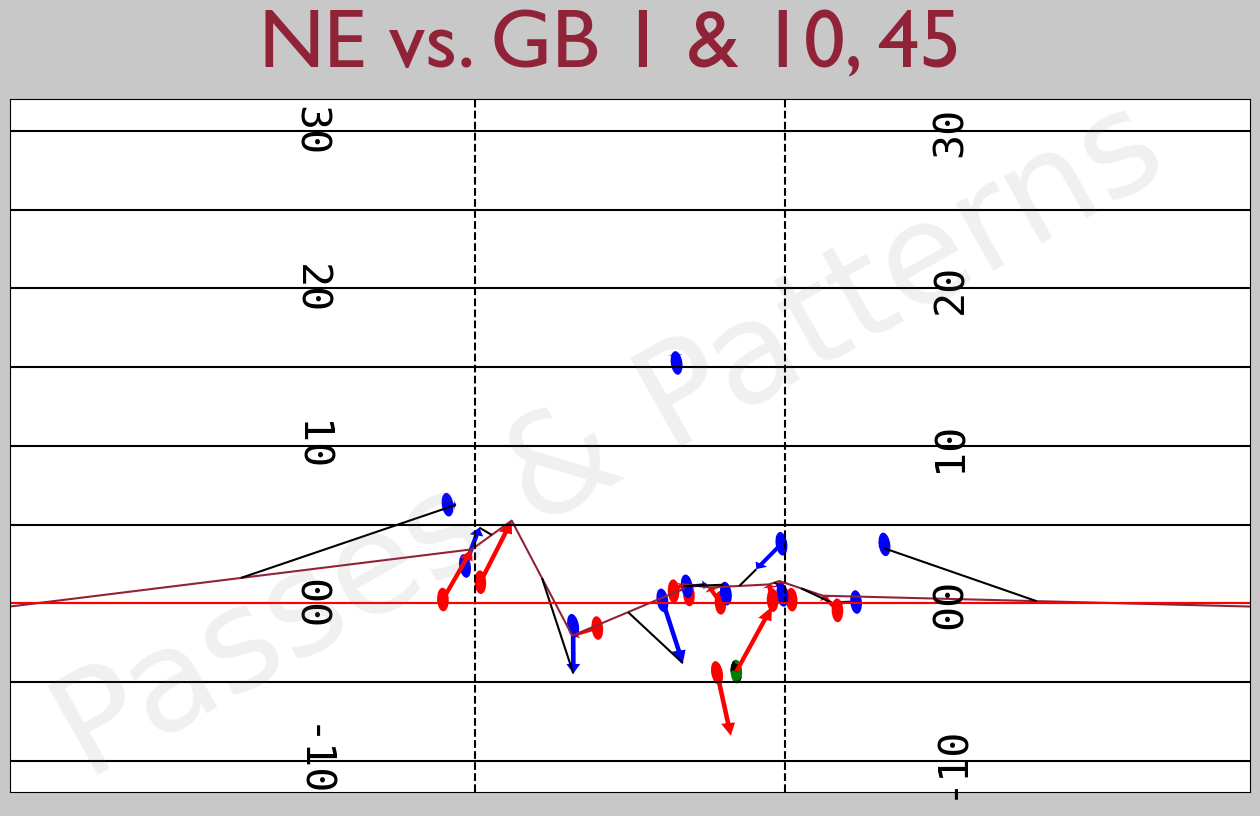

In [284]:
def plot_play(gameId, playId):
    game_data = games[games['gameId'] == gameId]
    play_data = handoff_plays[(handoff_plays['gameId'] == gameId) & (handoff_plays['playId'] == playId)]
    tracking_data = handoff_tracking[(handoff_tracking['gameId'] == gameId) & (handoff_tracking['playId'] == playId)]

    fig, ax = Concordia_figure(1, 1, figsize=(16, 9))

    # plotting the players as ellipses
    edgecolor = {"Box": 'orange', "Left": 'green', "Right": 'green', "Unknown": "purple", "High": "grey"}
    facecolor = {True: 'red', False: 'blue'}

    for r, row in tracking_data.iterrows():
        ax.add_patch(matplotlib.patches.Ellipse((row['y'], row['AdjustedX']), 0.5, 1.5,
                                                angle=row['AdjustedO'],
                                                facecolor='brown' if row['displayName'] == 'football' else ('green' if row["nflId"] == play_data["ballCarrierId"].values[0] else facecolor[row['OD']]),
                                                hatch="*" if row["nflId"] == play_data["ballCarrierId"].values[0] else None))
        # Adding momentum arrows
        if row['displayName'] != 'football':
            ax.add_patch(matplotlib.patches.Arrow(row['y'], row['AdjustedX'],
                                                row["s"] * numpy.cos(row["AdjustedDir"]), row["s"] * numpy.sin(row["AdjustedDir"]),
                                                facecolor='brown' if row['displayName'] == 'football' else facecolor[row['OD']],
                                                #hatch="*" if row["nflId"] == nfl_id else None))
            ))
        
    # Draw gaps
    ax.plot(play_data['Gaps'].values[0][:, 1], play_data['Gaps'].values[0][:, 0])

    # Draw gap assignments
    gap_midpoints = play_data["Gaps"].values[0]
    gap_midpoints = numpy.add(gap_midpoints[:-1], gap_midpoints[1:]) / 2
    gap_lines = numpy.stack([numpy.stack(play_data['GapDefenders'].values[0]), gap_midpoints], axis=1)
    gap_lines = numpy.flip(gap_lines, axis=-1)
    lc = matplotlib.collections.LineCollection(gap_lines, color='k')
    ax.add_collection(lc)

    # Hash Marks
    ax.axvline(33.3333, c='k', linestyle='--')  # hashmarks
    ax.axvline(53.33333 - 33.33333, c='k', linestyle='--')  # hashmarks
    
    ax.text(12, -10, "-10", font="monospace", fontsize=30, rotation=-90, va='center', ha='left')
    ax.text(12, 0, "00", font="monospace", fontsize=30, rotation=-90, va='center', ha='left')
    ax.text(12, 10, "10", font="monospace", fontsize=30, rotation=-90, va='center', ha='left')
    ax.text(12, 20, "20", font="monospace", fontsize=30, rotation=-90, va='center', ha='left')
    ax.text(12, 30, "30", font="monospace", fontsize=30, rotation=-90, va='center', ha='left')

    ax.text(41.333, -10, "-10", font="monospace", fontsize=30, rotation=90, va='center', ha='right')
    ax.text(41.333, 0, "00", font="monospace", fontsize=30, rotation=90, va='center', ha='right')
    ax.text(41.333, 10, "10", font="monospace", fontsize=30, rotation=90, va='center', ha='right')
    ax.text(41.333, 20, "20", font="monospace", fontsize=30, rotation=90, va='center', ha='right')
    ax.text(41.333, 30, "30", font="monospace", fontsize=30, rotation=90, va='center', ha='right')

    # ax.autoscale(False)  # We want to draw as many lines as necessary but not always graph them
    _ = [ax.axhline(x, c='k') for x in range(-10, 35, 5)]  # round(max(play_data["AdjustedX"] + 5)), 5)]
    ax.axhline(0, c='r')
    ax.grid(False)

    # xlim doesn't work because we fixed the scale of the plot
    ax.set(xticks=[], yticks=[],
        xlim=(0, 53.333))

    # Keeping the scale square
    # ax.axis('equal')


    fig.suptitle(play_data["possessionTeam"].values[0] + " vs. " + play_data["defensiveTeam"].values[0] + " " + 
                 play_data["down"].values[0].__int__().__str__() + " & " + play_data["yardsToGo"].values[0].__int__().__str__() + ", " + play_data["absoluteYardlineNumber"].__int__().__str__() )
    fig.savefig(resize=False)
    # plt.show()

sample_play = handoff_tracking.sample()
plot_play(sample_play['gameId'].values[0], sample_play['playId'].values[0])


## Advantage

n= 2383
YPP [2.709 5.881]
EPA [-0.283  0.105]
SR [0.292 0.501]


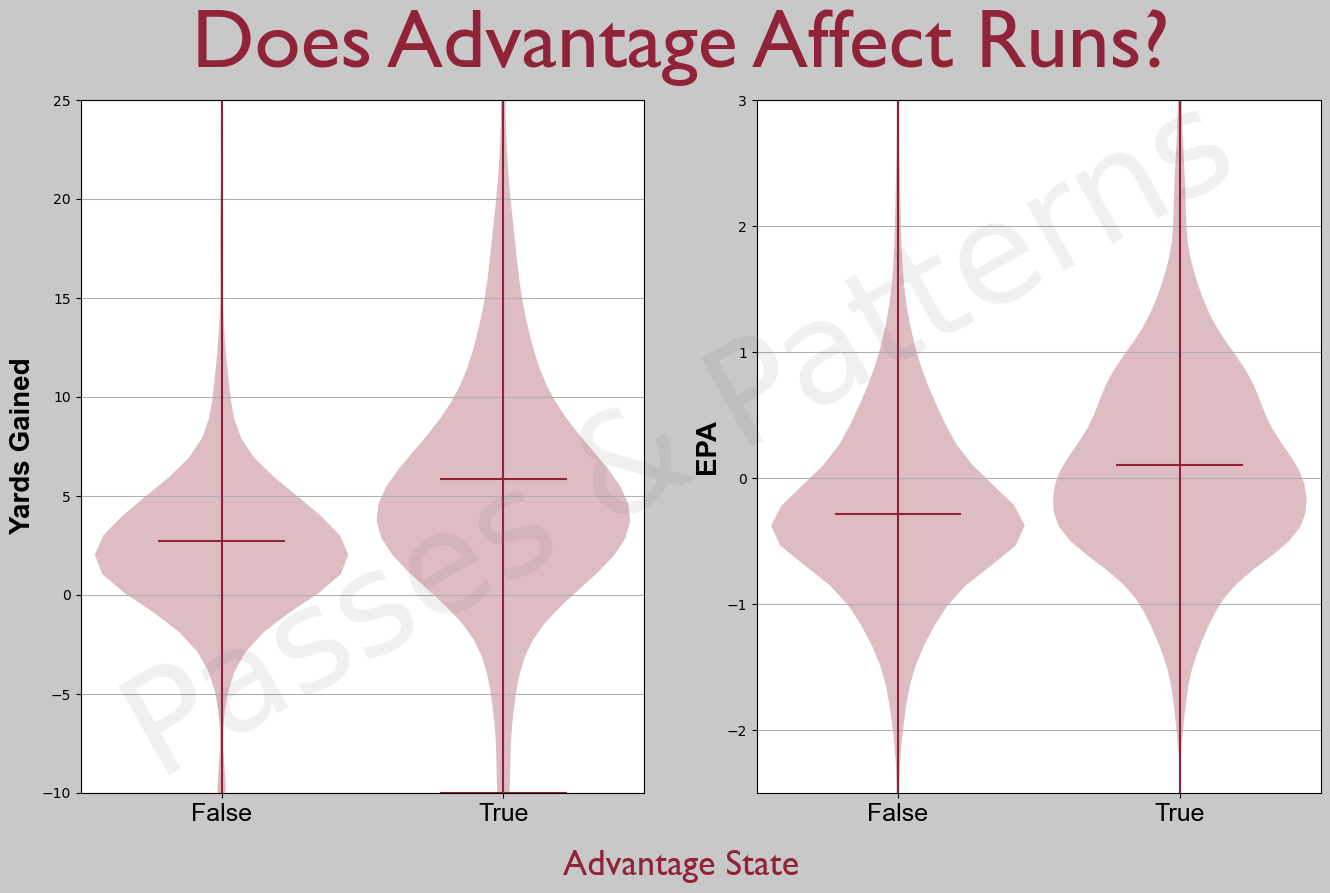

[0.122 0.178]


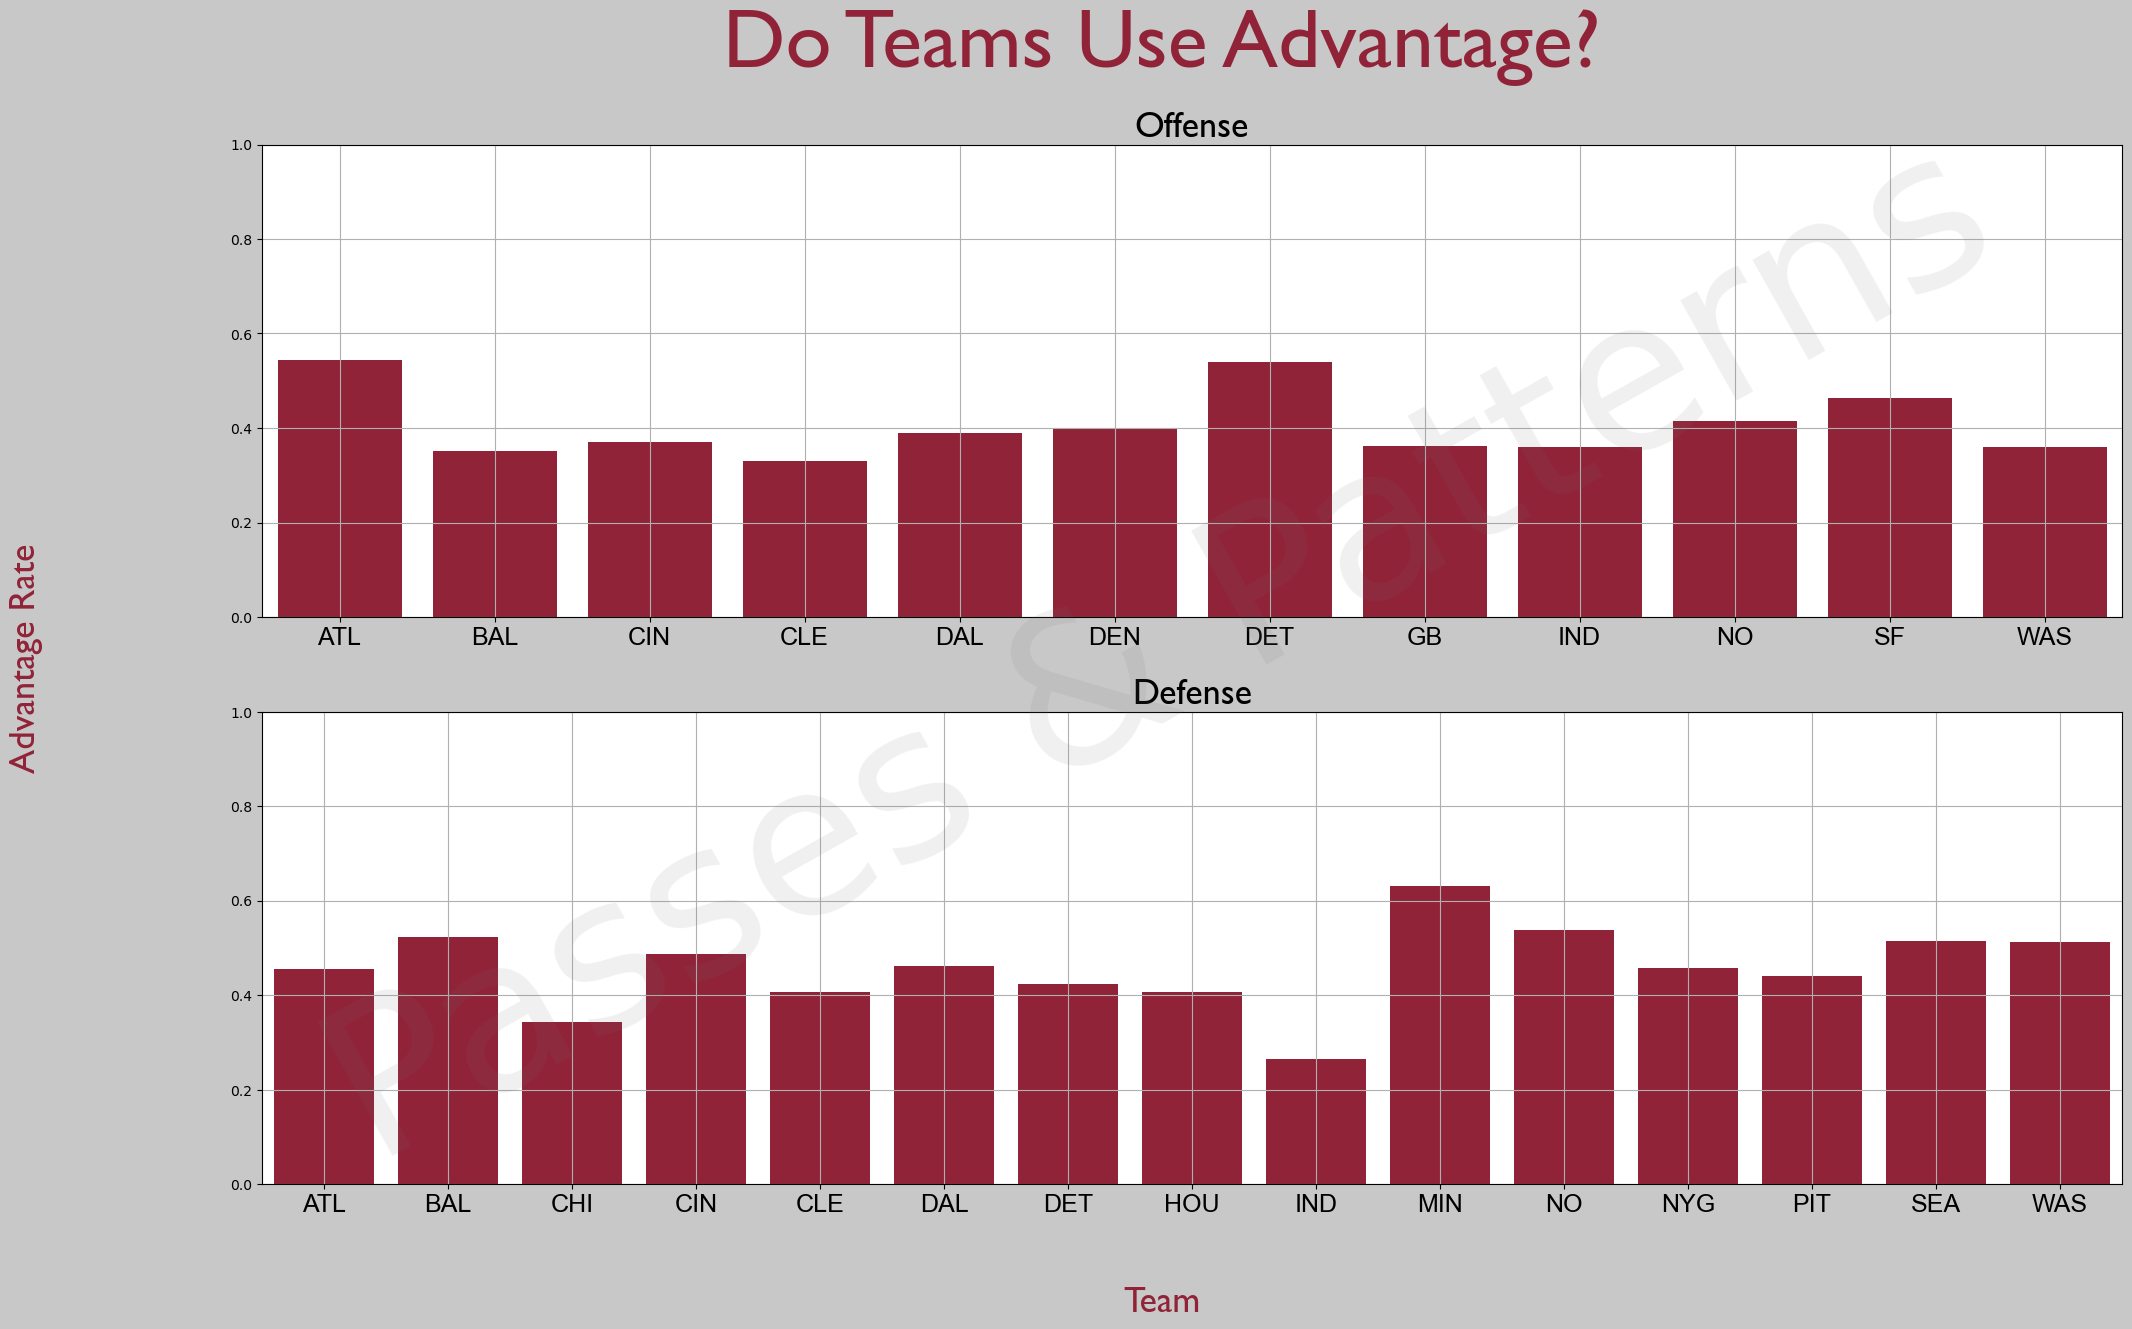

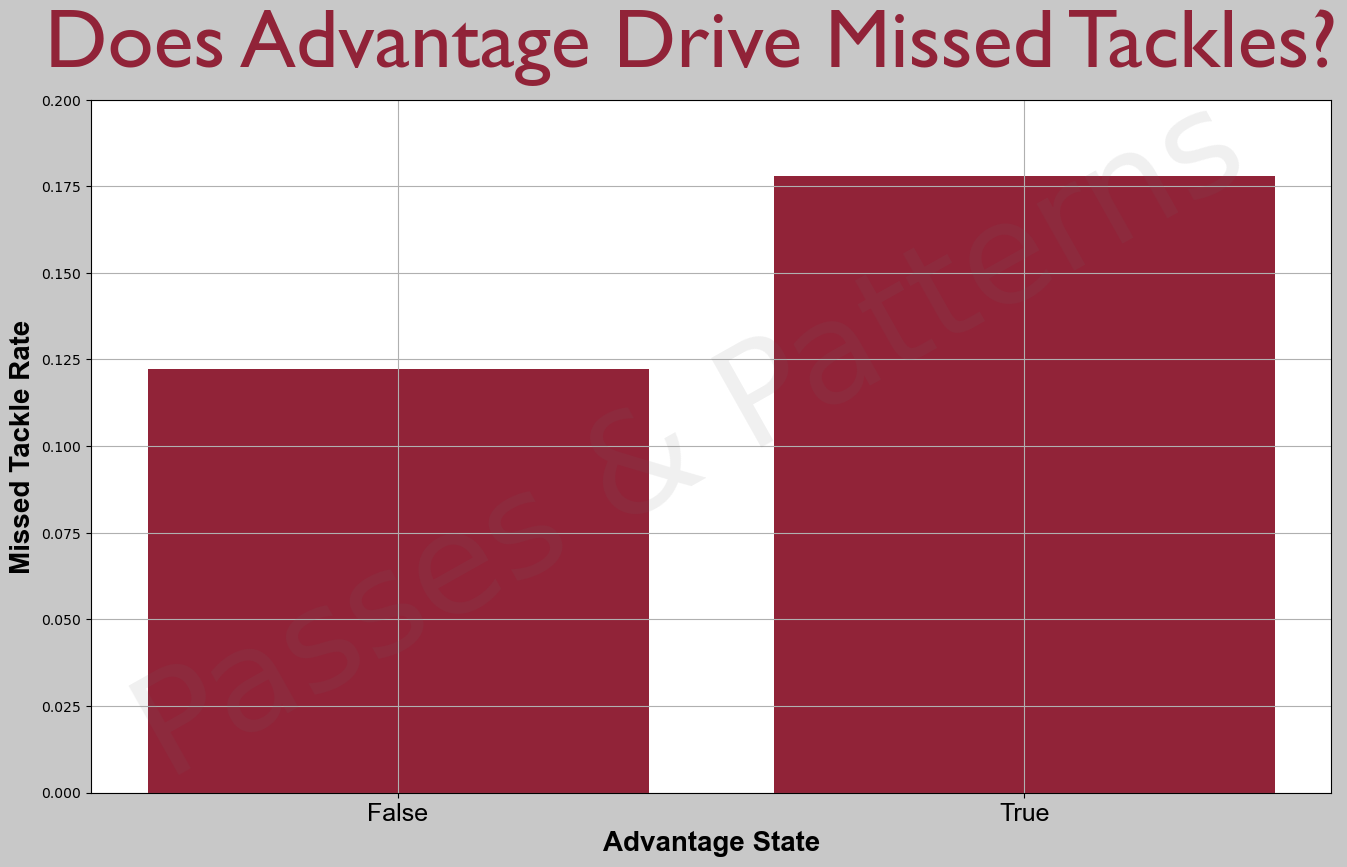

In [291]:


def does_advantage_matter():
    fig, axs = Concordia_figure(1, 2)
    data = [handoff_plays[(handoff_plays['Advantage'] == truth) & (~handoff_plays["playResult"].isna())]["playResult"].values for truth in [False, True]]
    print("YPP", numpy.round([numpy.nanmean(x) for x in data], 3))
    axs[0].violinplot(data, range(2), showmeans=True, widths=0.9)
    axs[0].set(xlim=(-0.5, 1.5), ylim=(-10, 25),
        xticks=range(2), xticklabels=([False, True]),
        ylabel="Yards Gained")
    data = [handoff_plays[(handoff_plays['Advantage'] == truth) & (~handoff_plays["expectedPointsAdded"].isna())]["expectedPointsAdded"].values for truth in [False, True]]    
    print("EPA", numpy.round([numpy.mean(x) for x in data], 3))
    print("SR", numpy.round([numpy.mean(numpy.greater(x, 0)) for x in data], 3))
    axs[1].violinplot(data, range(2), showmeans=True, widths=0.9)
    axs[1].set(xlim=(-0.5, 1.5), ylim=(-2.5, 3),
        xticks=range(2), xticklabels=([False, True]),
        ylabel="EPA")
    fig.suptitle("Does Advantage Affect Runs?")
    [ax.grid() for ax in axs]
    fig.supxlabel("Advantage State")
    fig.savefig(resize=False)
    plt.show()


def does_team_matter(threshold=100):
    fig, axs = Concordia_figure(2, 1, figsize=(24, 13.5))

    O_team = handoff_plays[~handoff_plays["Advantage"].isna()].groupby('possessionTeam', as_index=False).size()
    O_team = O_team[O_team['size'] > threshold]
    
    O_data = handoff_plays[handoff_plays["possessionTeam"].isin(O_team["possessionTeam"])].groupby("possessionTeam", as_index=False)["Advantage"].mean()
    axs[0].bar(range(O_data.__len__()), O_data["Advantage"])
    axs[0].set(xlim=(-0.5, O_data.__len__() - 0.5), ylim=(0, 1),
           xticks=range(O_data.__len__()), xticklabels=O_data["possessionTeam"],
           title="Offense")
    axs[0].grid()
    
    D_team = handoff_plays[~handoff_plays["Advantage"].isna()].groupby('defensiveTeam', as_index=False).size()
    D_team = D_team[D_team['size'] > threshold]
    
    D_data = handoff_plays[handoff_plays["defensiveTeam"].isin(D_team["defensiveTeam"])].groupby("defensiveTeam", as_index=False)["Advantage"].mean()
    axs[1].bar(range(D_data.__len__()), D_data["Advantage"])
    axs[1].set(xlim=(-0.5, D_data.__len__() - 0.5), ylim=(0, 1),
           xticks=range(D_data.__len__()), xticklabels=D_data["defensiveTeam"],
           title="Defense")
    axs[1].grid()
    fig.suptitle("Do Teams Use Advantage?")
    fig.supxlabel("Team")
    fig.supylabel("Advantage Rate")
    fig.savefig(resize=False)


def advantage_for_missed_tackles():
    fig, ax = Concordia_figure()

    data = [numpy.nanmean(handoff_plays[handoff_plays["Advantage"] == truth]["missed_tackle"].values) for truth in [0, 1]]
    print(numpy.round(data, 3))
    ax.bar(range(2), data)
    ax.set(xlabel="Advantage State", ylabel="Missed Tackle Rate",
           ylim=(0, 0.2),
           xticks=range(2), xticklabels=[False, True])
    ax.grid()
    fig.suptitle("Does Advantage Drive Missed Tackles?")
    fig.savefig(resize=False)


def advantage_flying_bricks():
    pass

print("n=", handoff_plays[~handoff_plays["Advantage"].isna()].__len__())
does_advantage_matter()
does_team_matter(75)
advantage_for_missed_tackles()


## Test

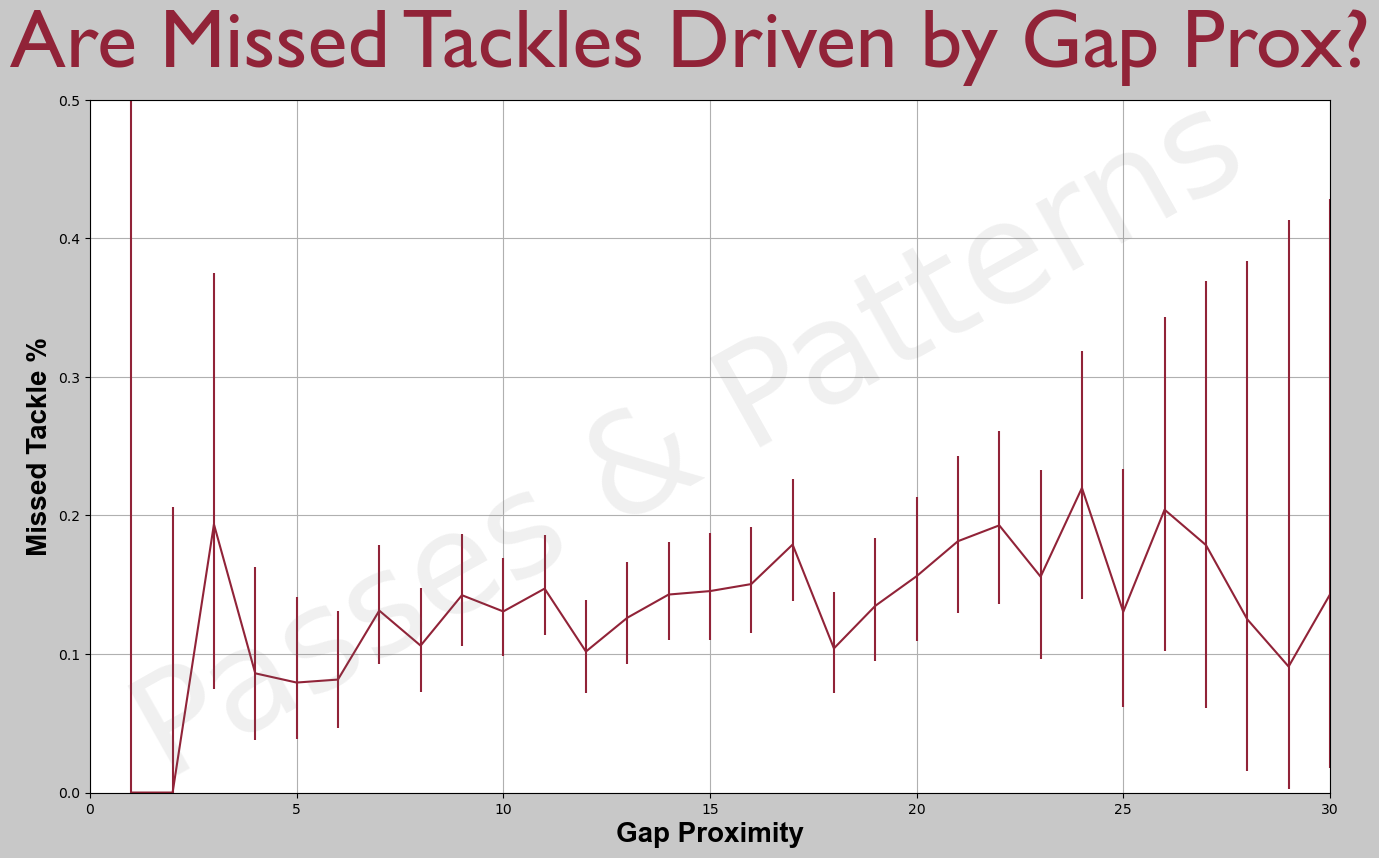

In [286]:
def gap_prox_as_proxy():

       # print(advantage_data.head())
       # print(advantage_data[advantage_data["R/P"] == "RUN"].groupby("Advantage")["Yards Gained"].mean())

       fig, ax = Concordia_figure(1, 1)
       ax.continuous_errorbar(temp["Rusher_Advantage"], temp["playResult"])
       ax.grid()
       ax.set(xlabel="Gap Proximity (Yards)", ylabel="Yards Gained",
              xlim=(0, 25), ylim=(0, 10))
       fig.suptitle("Is Gap Prox a Proxy for Advantage?")
       fig.savefig(resize=False)


def missed_tackle_distribution():
       fig, ax = Concordia_figure()
       ax.set(xlim=(0, 30), ylim=(0, 0.5),
              xlabel="Gap Proximity", ylabel="Missed Tackle %")
       ax.binomial_errorbar(handoff_plays["Rusher_Advantage"], handoff_plays["missed_tackle"])
       ax.grid()
       fig.suptitle("Are Missed Tackles Driven by Gap Prox?")
       fig.savefig(resize=False)


missed_tackle_distribution()